# Access Database-Files to explore and summerise Data

In [1]:
import pandas as pd
import numpy as np
import pylab as plt
from tables import *
import sqlite3
import openpyxl as oxl

In [2]:
# aims 
    # plot single data and highlight outliers in data
    # compare epsilon values of different evaluation methods
    # summarise data
    # calculate epsilon values with SSB
    # visulise data for epsilon SSB
    # store summarised data in hd5

In [3]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2015-03-25/data_eval_new/"
file_name = "int_norm_20150325_bgd_new.h5"
path_comp = '/Volumes/friebelm/PhD/NU Plasma/Measurements/compilation/'
sum_file = "int_norm_comp_new.h5"

In [4]:
hdf5_file = pd.HDFStore(path+file_name)
#hdf5_sum_file = pd.HDFStore(path_comp+sum_file)

# Methods for Outlier rejection, Summarise and SSB Calculation

In [5]:
def mad_based_outlier(points, thresh=3.5):
        """
        Returns a boolean array with True if points are outliers and False
        otherwise.

        Parameters:
        -----------
            points : An numobservations by numdimensions array of observations
            thresh : The modified z-score to use as a threshold. Observations with
                a modified z-score (based on the median absolute deviation) greater
                than this value will be classified as outliers.

        Returns:
        --------
            mask : A numobservations-length boolean array.

        References:
        ----------
            Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
            Handle Outliers", The ASQC Basic References in Quality Control:
            Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
        """
        if len(points.shape) == 1:
            points = points[:,None]
        median = np.median(points, axis=0)
        diff = np.sum((points - median)**2, axis=-1)
        diff = np.sqrt(diff)
        med_abs_deviation = np.median(diff)

        modified_z_score = 0.6745 * diff / med_abs_deviation

        return modified_z_score > thresh

#outlier rejection
def mad_outlier_rejection(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(~mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Cycle", "Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Cycle"] = df["Cycle"]
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier_mean(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def SE(x):
    SE = np.std(x) / x.count()
    return SE

def SD2(x):
    SD2 = np.nanstd(x, ddof=1) * 2
    return SD2

def df_mean(df):
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).mean()
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    columns = ["Filenumber", "Sample"]
    columns.extend(df.drop(["Filenumber", "Sample"], axis=1).columns)
    df = pd.DataFrame(df, columns = columns)
    
    return df
    
def df_SD(df):    
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).agg([np.mean, SD2])
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    
    return df

def SSB(df, std, multi_fac):
    ### calculate Standard-Sample Bracketing ###

    # bracketing standard #
    std_used = std
    df_to_use = df
    # determine at which position the samples are which are bracketed
    sub_index = df_to_use[(df_to_use["Sample"].shift(1) == df_to_use["Sample"].shift(-1)) & (df_to_use["Sample"].shift(1) == std_used)].index
    # remove measurements with values below 0.1V
    corr_values = df_to_use
    # extract only standard data
    corr_values_2 = df_to_use[df_to_use["Sample"] == std_used]

    # save sample names
    sample = corr_values["Sample"]
    sample_2 = corr_values_2["Sample"]

    # remove sample names from dataframe for calculation
    new = corr_values[corr_values.columns[corr_values.dtypes != 'object']]
    new_2 = corr_values_2[corr_values_2.columns[corr_values_2.dtypes != 'object']]

    # calculate bracketing 
    epsilon_NIST =  ((new / ((new.shift(1) + new.shift(-1))/2))-1)*multi_fac
    epsilon_2 = ((new_2 / ((new_2.shift(1) + new_2.shift(-1))/2))-1)*multi_fac
    # reinsert samples names
    epsilon_NIST["Sample"] = sample
    epsilon_2["Sample"] = sample_2

    # select samples by bracketing index
    epsilon_NIST = epsilon_NIST[new.index.isin(sub_index)]
    #epsilon_NIST= epsilon_NIST[epsilon_NIST["sample"].str.contains("opt")]
    # select only bracketed sample measurements in dataframe
    epsilon_NIST= epsilon_NIST[epsilon_NIST["Sample"] != std_used]
    # select only bracketed standard measurements in dataframe
    epsilon_2 = epsilon_2[epsilon_2["Sample"] == std_used]
    # append bracketed sample and standard measurements
    epsilon_comp = epsilon_NIST.append(epsilon_2, ignore_index=False)
    # sort dataframe by datetime
    epsilon_comp = epsilon_comp.sort_index(axis=0)
    
    return epsilon_comp

def plot_epsilon(df, sel_ratio, std, xlim):
    x = range(1, len(epsilon_sum.index)+1)
    plt.errorbar(epsilon_sum[sel_ratio]["mean"], x, xerr = epsilon_sum[sel_ratio]["SD2"], ls='none', marker="o")
    plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
    plt.xlim(xlim)
    plt.ylim([0.5, len(epsilon_sum.index)+1])
    plt.yticks(x, epsilon_sum.index, size='small', rotation=0)
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
    plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
    #savefig(path+"epsilon_118.pdf", bbox_inches='tight')

# Datafiles in Database

In [6]:
hdf5_file.keys()

['/raw_data/baselines',
 '/raw_data/signals_raw',
 '/raw_data/signals_zero',
 '/evaluation/bgd_outlier_corr/df_bgd_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118_120/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118

# Plot raw data and check measurement

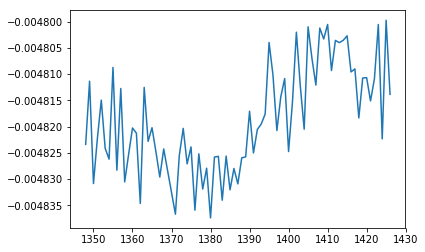

In [7]:
# Check Baselines
column = "116"

baseline = hdf5_file['/raw_data/baselines']
#baseline = baseline[baseline["Filenumber"] == 8979]
plt.plot(baseline["Filenumber"], baseline[column])
plt.show()

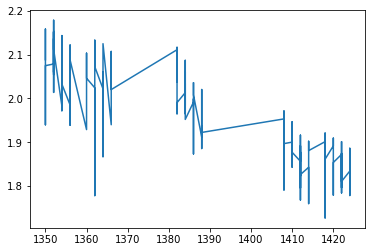

In [8]:
# Check Signals
column = "122"
sample = "SPEX 100ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_sub = signals[signals["Sample"] == sample]
plt.plot(signals_sub["Filenumber"], signals_sub[column])
plt.show()

In [9]:
df_mean(signals[signals["118"] < 0.05])

,Filenumber,Sample,110,111,112,113,114,115,116,117,...,120_2,121_2,122_2,123_2,124_2,125_2,126_2,127_2,129_2,131_2
Date,,,,,,,,,,,,,,,,,,,,,
2015-03-25 14:17:00,1348,blank sol,0.000160,0.000136,0.000250,0.000104,0.000240,0.000023,0.000621,0.000290,...,0.001629,5.407300e-07,0.000196,0.000017,0.000291,0.000059,0.000187,0.019317,0.011801,0.009695
2015-03-25 16:18:00,1358,blank sol,0.000141,0.000126,0.000242,0.000106,0.000246,0.000034,0.000960,0.000490,...,0.002459,1.102264e-05,0.000317,0.000015,0.000456,0.000037,0.000170,0.017341,0.011414,0.009390
2015-03-25 18:29:00,1368,blank sol,0.000158,0.000124,0.000245,0.000085,0.000261,0.000027,0.000917,0.000458,...,0.002306,1.594483e-05,0.000294,0.000004,0.000422,0.000051,0.000189,0.017475,0.011233,0.009241
2015-03-25 20:55:00,1380,blank sol,0.000156,0.000134,0.000258,0.000113,0.000258,0.000051,0.001092,0.000553,...,0.002846,1.097519e-05,0.000370,0.000012,0.000523,0.000045,0.000165,0.037310,0.011538,0.009500
2015-03-25 22:57:00,1390,blank sol,0.000152,0.000124,0.000250,0.000104,0.000238,0.000037,0.000988,0.000499,...,0.002467,8.370255e-06,0.000311,0.000013,0.000449,0.000038,0.000136,0.072445,0.011409,0.009378
2015-03-26 01:00:00,1400,blank sol,0.000134,0.000128,0.000273,0.000100,0.000268,0.000037,0.001420,0.000720,...,0.003480,6.083265e-06,0.000451,0.000022,0.000616,0.000050,0.000130,0.104632,0.011514,0.009469
2015-03-26 02:12:00,1406,blank sol,0.000137,0.000121,0.000296,0.000112,0.000287,0.000057,0.001607,0.000829,...,0.003679,1.330904e-05,0.000490,0.000004,0.000660,0.000040,0.000140,0.115793,0.011180,0.009175
2015-03-26 04:14:00,1416,blank sol,0.000115,0.000116,0.000271,0.000097,0.000257,0.000045,0.001549,0.000797,...,0.003824,1.298476e-05,0.000502,0.000005,0.000684,0.000048,0.000137,0.117301,0.011005,0.009066
2015-03-26 06:16:00,1426,blank sol,0.000131,0.000112,0.000258,0.000101,0.000251,0.000043,0.001240,0.000617,...,0.003054,8.441955e-06,0.000392,0.000010,0.000532,0.000040,0.000136,0.111240,0.011170,0.009202


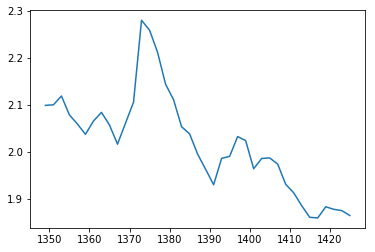

In [10]:
# Check Signals - mean
column = "122"
sample = "NIST 100ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_mean = df_mean(signals)
signals_sub_mean = signals_mean[signals_mean["Sample"] == sample]
plt.plot(signals_sub_mean["Filenumber"], signals_sub_mean[column])
plt.show()

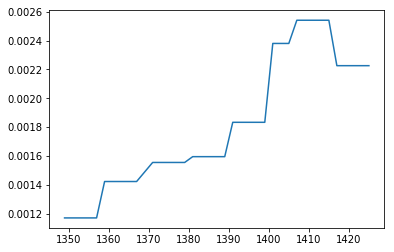

In [11]:
# Check background 
column = "118"
sample = "NIST 100ppb"

background = hdf5_file['/evaluation/bgd_outlier_corr/df_bgd_corr']
background_sub = background[background["Sample"] == sample]
plt.plot(background_sub["Filenumber"], background_sub[column])
plt.show()

In [12]:
background_mean = df_mean(background)

In [46]:
# Create Dataframe for signals_bgd corr
signals["Te/Sn"] = (signals["126_2"]/18.8066)/(signals["118"]/24.223)
signals["Cd/Sn"] = (signals["111"]/12.9447)/(signals["118"]/24.223)

In [51]:
signals_mean = signals.groupby("Filenumber").agg("mean")

# Outlier rejection

In [129]:
bgd_method = 'bgd_outlier_corr' #'no_bgd_corr'
norm_ratio = "r_122_118"
interf_corr = "Te125_Xe129_corr"

In [130]:
df_all_raw_rat = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_raw_ratios_af_interf_corr']
df_mean_int_corr = df_mean(hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_amount_interf_corr'])
df_all = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_internal_norm']

In [131]:
column = "124/118"
sample = "NIST 100ppb"

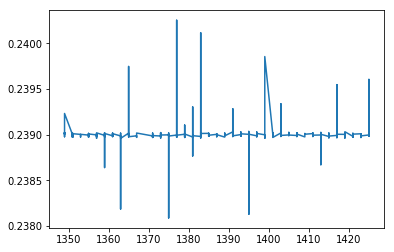

In [132]:
# Check ratios for bracketing standard

df_all_sub = df_all[df_all["Sample"] == sample]
plt.plot(df_all_sub["Filenumber"], df_all_sub[column])
plt.show()

In [133]:
df_outlier_rej_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier)

df_outlier_rej_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in divide
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in divide


In [134]:
df_outlier_rej_int

,Sample,Num_of_Ana_Cyc,Cycle,Filenumber,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118
Date,,,,,,,,,,,,,
2015-03-25 14:27:00,NIST 100ppb,2,1,1349,0.040147,0.027187,0.013940,0.600283,0.316720,0.354612,1.346037,0.19125,0.239011
2015-03-25 14:27:00,NIST 100ppb,2,2,1349,0.040144,0.027185,0.013945,0.600291,NaN,0.354623,1.346039,NaN,0.239019
2015-03-25 14:27:00,NIST 100ppb,2,3,1349,0.040135,0.027179,0.013941,0.600319,0.316713,0.354623,1.346066,0.19125,0.239004
2015-03-25 14:27:00,NIST 100ppb,2,4,1349,0.040144,0.027181,0.013943,0.600308,0.316713,0.354608,1.346049,0.19125,0.239024
2015-03-25 14:27:00,NIST 100ppb,2,5,1349,0.040149,0.027185,0.013941,0.600341,0.316723,0.354623,1.345984,0.19125,0.238989
2015-03-25 14:27:00,NIST 100ppb,2,6,1349,0.040137,0.027176,0.013943,0.600319,0.316729,0.354619,1.346025,0.19125,0.239010
2015-03-25 14:27:00,NIST 100ppb,2,7,1349,0.040154,0.027191,0.013944,0.600339,0.316721,0.354623,1.346046,0.19125,0.238989
2015-03-25 14:27:00,NIST 100ppb,2,8,1349,0.040138,0.027186,0.013935,NaN,NaN,0.354603,1.346067,NaN,0.239012
2015-03-25 14:27:00,NIST 100ppb,2,9,1349,0.040148,0.027181,0.013937,0.600298,0.316719,0.354608,1.346011,NaN,0.238991


In [135]:
df_outlier_int[df_outlier_int[column].notnull()][column]

Filenumber  Date               
1349        2015-03-25 14:27:00    0.239231
1350        2015-03-25 14:39:00    0.238538
1356        2015-03-25 15:54:00    0.239416
1359        2015-03-25 16:29:00    0.238639
1360        2015-03-25 16:41:00    0.239348
1363        2015-03-25 17:27:00    0.238184
1365        2015-03-25 17:52:00    0.239746
1366        2015-03-25 18:04:00    0.238801
            2015-03-25 18:04:00    0.238605
1375        2015-03-25 19:53:00    0.238087
1376        2015-03-25 20:05:00    0.238690
1377        2015-03-25 20:17:00    0.240252
1379        2015-03-25 20:42:00    0.239104
1381        2015-03-25 21:05:00    0.238766
            2015-03-25 21:05:00    0.239302
1383        2015-03-25 21:30:00    0.240114
1384        2015-03-25 21:43:00    0.239279
1386        2015-03-25 22:07:00    0.238803
1391        2015-03-25 23:08:00    0.239283
1392        2015-03-25 23:20:00    0.239154
1394        2015-03-25 23:45:00    0.239593
            2015-03-25 23:45:00    0.239523


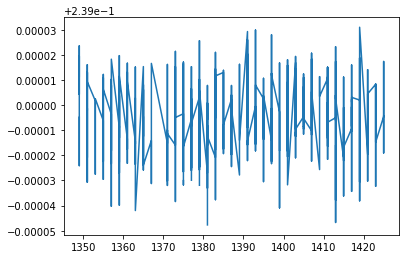

In [136]:
# Check sample measurements
df = df_outlier_rej_int

df_sub = df[df["Sample"] == sample]
plt.plot(df_sub["Filenumber"], df_sub[column])
plt.show()

In [137]:
df[df["Sample"] == sample][column].std()

1.3087880951972007e-05

In [138]:
df_outlier_rej_int["Cd/Sn"] = signals[signals["Sample"] != "blank sol"]["Cd/Sn"]
df_outlier_rej_int["Te/Sn"] = signals[signals["Sample"] != "blank sol"]["Te/Sn"]

In [139]:
data_mean_int = df_mean(df_outlier_rej_int)
data_mean_int_sd = df_SD(df_outlier_rej_int)

data_mean_raw = df_mean(df_outlier_rej_raw)
data_mean_raw_sd = df_SD(df_outlier_rej_raw)

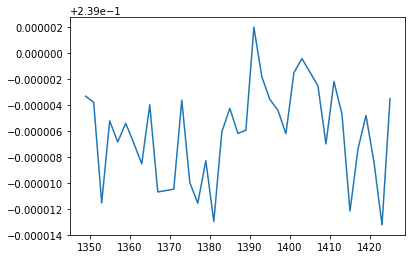

In [140]:
# Check sample measurements
df_mean_used = data_mean_int

df_mean_sub = df_mean_used[df_mean_used["Sample"] == sample]
plt.plot(df_mean_sub["Filenumber"], df_mean_sub[column])
plt.show()

In [141]:
data_mean_int

,Filenumber,Sample,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118,Cd/Sn,Te/Sn
Date,,,,,,,,,,,,,
2015-03-25 14:27:00,1349,NIST 100ppb,0.040146,0.027183,0.013941,0.600315,0.316720,0.354613,1.346022,0.19125,0.238997,0.000021,0.000024
2015-03-25 14:39:00,1350,SPEX 100ppb,0.040147,0.027181,0.013955,0.600331,0.316725,0.354618,1.346020,0.19125,0.238991,0.000024,0.000026
2015-03-25 14:52:00,1351,NIST 100ppb,0.040142,0.027178,0.013944,0.600323,0.316724,0.354623,1.346026,0.19125,0.238996,0.000024,0.000025
2015-03-25 15:04:00,1352,SPEX 100ppb,0.040145,0.027179,0.013956,0.600316,0.316725,0.354612,1.346022,0.19125,0.238990,0.000023,0.000025
2015-03-25 15:16:00,1353,NIST 100ppb,0.040149,0.027182,0.013946,0.600330,0.316731,0.354619,1.346017,0.19125,0.238988,0.000022,0.000026
2015-03-25 15:29:00,1354,SPEX 100ppb,0.040146,0.027183,0.013956,0.600330,0.316723,0.354617,1.346015,0.19125,0.238984,0.000024,0.000024
2015-03-25 15:41:00,1355,NIST 100ppb,0.040148,0.027185,0.013946,0.600329,0.316733,0.354615,1.346015,0.19125,0.238995,0.000023,0.000024
2015-03-25 15:54:00,1356,SPEX 100ppb,0.040146,0.027183,0.013954,0.600325,0.316729,0.354615,1.346042,0.19125,0.238995,0.000022,0.000024
2015-03-25 16:06:00,1357,NIST 100ppb,0.040145,0.027181,0.013946,0.600331,0.316732,0.354617,1.346033,0.19125,0.238993,0.000025,0.000028


In [142]:
date_list = []
                         
data_mean_raw = data_mean_raw.drop(date_list)
data_mean_int = data_mean_int.drop(date_list)
data_mean_raw_sd = data_mean_raw_sd.drop(date_list)
data_mean_int_sd = data_mean_int_sd.drop(date_list)

In [143]:
drop_sum = []

In [144]:

data_mean_int_sum = data_mean_int.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_int_sum = data_mean_int_sum.drop("Filenumber", axis=1)

In [145]:
data_mean_raw_sum = data_mean_raw.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_raw_sum = data_mean_raw_sum.drop("Filenumber", axis=1)

In [146]:
data_mean_int_sum

112/118                   114/118                   115/118  \
                   mean       SD2 count      mean       SD2 count      mean   
Sample                                                                        
BHVO-2 1_1(2)  0.040148       NaN     1  0.027183       NaN     1  0.013945   
BHVO-2 1_2(1)  0.040148       NaN     1  0.027185       NaN     1  0.013945   
BHVO-2 2_1     0.040156       NaN     1  0.027191       NaN     1  0.013945   
BHVO-2 2_2     0.040150       NaN     1  0.027185       NaN     1  0.013946   
J1 1_1         0.040151       NaN     1  0.027187       NaN     1  0.013944   
J2 1_1         0.040154       NaN     1  0.027193       NaN     1  0.013948   
NIST 100ppb    0.040148  0.000004    38  0.027182  0.000004    38  0.013946   
SPEX 100ppb    0.040147  0.000003    20  0.027182  0.000004    20  0.013956   
SPEX1 1_1(1)   0.040152       NaN     1  0.027188       NaN     1  0.013946   
SPEX1 2_1      0.040148       NaN     1  0.027184       NaN     1  0.013947   
SPEX1 II 3_1   0.040147       NaN     1  0.027182       NaN     1  0.013945   
SPEX1 II 4_1   0.040148       NaN     1  0.027187       NaN     1  0.013945   

                                116/118  ...  122/118   124/118            \
                    SD2 count      mean  ...    count      mean       SD2   
Sample                                   ...                                
BHVO-2 1_1(2)       NaN     1  0.600324  ...        1  0.238992       NaN   
BHVO-2 1_2(1)       NaN     1  0.600327  ...        1  0.238988       NaN   
BHVO-2 2_1          NaN     1  0.600332  ...        1  0.238995       NaN   
BHVO-2 2_2          NaN     1  0.600329  ...        1  0.239001       NaN   
J1 1_1              NaN     1  0.600326  ...        1  0.238995       NaN   
J2 1_1              NaN     1  0.600344  ...        1  0.238995       NaN   
NIST 100ppb    0.000003    38  0.600335  ...       38  0.238994  0.000007   
SPEX 100ppb    0.000002    20  0.600332  ...       20  0.238992  0.000008   
SPEX1 1_1(1)        NaN     1  0.600337  ...        1  0.238996       NaN   
SPEX1 2_1           NaN     1  0.600341  ...        1  0.238992       NaN   
SPEX1 II 3_1        NaN     1  0.600328  ...        1  0.238989       NaN   
SPEX1 II 4_1        NaN     1  0.600333  ...        1  0.238985       NaN   

                        Cd/Sn                     Te/Sn                  
              count      mean       SD2 count      mean       SD2 count  
Sample                                                                   
BHVO-2 1_1(2)     1  0.000030       NaN     1  0.000045       NaN     1  
BHVO-2 1_2(1)     1  0.000036       NaN     1  0.000030       NaN     1  
BHVO-2 2_1        1  0.000035       NaN     1  0.000027       NaN     1  
BHVO-2 2_2        1  0.000034       NaN     1  0.000027       NaN     1  
J1 1_1            1  0.000053       NaN     1  0.000027       NaN     1  
J2 1_1            1  0.000039       NaN     1  0.000029       NaN     1  
NIST 100ppb      38  0.000024  0.000003    38  0.000023  0.000004    38  
SPEX 100ppb      20  0.000024  0.000003    20  0.000023  0.000003    20  
SPEX1 1_1(1)      1  0.000023       NaN     1  0.000024       NaN     1  
SPEX1 2_1         1  0.000035       NaN     1  0.000029       NaN     1  
SPEX1 II 3_1      1  0.000014       NaN     1  0.000029       NaN     1  
SPEX1 II 4_1      1  0.000026       NaN     1  0.000030       NaN     1  

[12 rows x 33 columns]

In [147]:
date_list = []


epsilon_int_NIST = SSB(data_mean_int.drop(date_list), "NIST 100ppb", 10000)
delta_raw_NIST = SSB(data_mean_raw.drop(date_list), "NIST 100ppb", 1000)
epsilon_int_SPEX = SSB(data_mean_int.drop(date_list), "SPEX 100ppb", 10000)
delta_raw_SPEX = SSB(data_mean_raw.drop(date_list), "SPEX 100ppb", 1000)

In [148]:
epsilon_int_NIST = epsilon_int_NIST.drop(["Cd/Sn", "Te/Sn"], axis=1)
epsilon_int_SPEX = epsilon_int_SPEX.drop(["Cd/Sn", "Te/Sn"], axis=1)

In [149]:
epsilon_int_SPEX

,Filenumber,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118,Sample
Date,,,,,,,,,,,
2015-03-25 14:39:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SPEX 100ppb
2015-03-25 14:52:00,0.000000,-0.852922,-0.640621,-8.037593,-0.009109,-0.041234,0.216286,0.037549,0.000000e+00,0.248512,NIST 100ppb
2015-03-25 15:04:00,0.000000,-0.418939,-0.867265,0.233477,-0.246017,0.031773,-0.150038,0.028634,-1.110223e-12,0.088650,SPEX 100ppb
2015-03-25 15:16:00,0.000000,0.805861,0.447561,-7.057844,0.117186,0.210932,0.126271,-0.008531,0.000000e+00,0.057985,NIST 100ppb
2015-03-25 15:29:00,0.000000,0.227802,0.525171,0.671230,0.167941,-0.127278,0.104049,-0.123506,-1.110223e-12,-0.323745,SPEX 100ppb
2015-03-25 15:41:00,0.000000,0.406295,0.592801,-6.899290,0.027867,0.224441,-0.027822,-0.100117,2.220446e-12,0.220516,NIST 100ppb
2015-03-25 15:54:00,-7.369197,-0.337696,0.404861,-0.950588,-0.024905,0.113203,0.045027,0.128538,0.000000e+00,0.182937,SPEX 100ppb
2015-03-25 16:41:00,7.358352,0.489363,-0.352012,-0.588834,-0.070139,0.006406,-0.137605,0.025095,0.000000e+00,0.019865,SPEX 100ppb
2015-03-25 16:53:00,0.000000,-0.044366,-0.517883,-8.714543,0.058995,0.035656,0.051019,-0.050894,-1.110223e-12,-0.133182,NIST 100ppb


In [150]:

date_list = []

epsilon_int_NIST = epsilon_int_NIST.drop(date_list)
delta_raw_NIST = delta_raw_NIST.drop(date_list)

In [151]:
def epsilon_process(df):
    df = df[(df["Filenumber"] >= -5) & (df["Filenumber"] <= 5)]
    df["Filenumber"] = data_mean_int["Filenumber"].ix[df.index]
    return df

In [152]:
epsilon_int_NIST = epsilon_process(epsilon_int_NIST)
delta_raw_NIST = epsilon_process(delta_raw_NIST)
epsilon_int_SPEX = epsilon_process(epsilon_int_SPEX)
delta_raw_SPEX = epsilon_process(delta_raw_SPEX)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [153]:
epsilon_int_NIST

,Filenumber,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118,Sample
Date,,,,,,,,,,,
2015-03-25 14:39:00,1350,0.667048,-0.058979,8.947463,0.194411,0.090375,-0.004010,-0.028282,0.000000e+00,-0.236021,SPEX 100ppb
2015-03-25 14:52:00,1351,-1.224722,-1.677188,0.529053,-0.000857,-0.061055,0.182264,0.046624,0.000000e+00,0.152071,NIST 100ppb
2015-03-25 15:04:00,1352,-0.185942,-0.337136,7.670237,-0.177047,-0.068962,-0.246294,-0.000193,-1.110223e-12,-0.108923,SPEX 100ppb
2015-03-25 15:16:00,1353,0.933612,0.300378,0.863279,0.068767,0.071573,0.009044,-0.024683,-3.330669e-12,-0.294072,NIST 100ppb
2015-03-25 15:29:00,1354,-0.492147,-0.257592,7.319281,0.011444,-0.281320,0.002800,-0.007429,-1.110223e-12,-0.301122,SPEX 100ppb
2015-03-25 15:41:00,1355,0.212827,1.123513,-0.166927,-0.026086,0.062156,-0.079334,-0.071046,2.220446e-12,0.166299,NIST 100ppb
2015-03-25 15:54:00,1356,-0.107584,0.195448,6.321770,-0.093263,-0.105399,-0.026490,0.136619,-1.110223e-12,0.026392,SPEX 100ppb
2015-03-25 16:06:00,1357,-0.218348,0.473743,-0.280872,0.009813,0.113196,0.040891,0.128444,0.000000e+00,-0.064331,NIST 100ppb
2015-03-25 16:29:00,1359,-0.535517,-2.217691,0.878715,0.041761,-0.217622,0.008507,-0.085248,-1.110223e-12,0.061874,NIST 100ppb


In [154]:
epsilon_NIST_sum = np.round(epsilon_int_NIST.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_NIST_sum = np.round(delta_raw_NIST.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
epsilon_SPEX_sum = np.round(epsilon_int_SPEX.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_SPEX_sum = np.round(delta_raw_SPEX.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)

epsilon_sum_all = epsilon_NIST_sum.append(epsilon_SPEX_sum)
epsilon_sum_all = epsilon_sum_all.drop("Filenumber", axis=1)
delta_raw_sum_all = delta_raw_NIST_sum.append(delta_raw_SPEX_sum)
delta_raw_sum_all = delta_raw_sum_all.drop("Filenumber", axis=1)

In [155]:
epsilon_sum_all

112/118              114/118              115/118               \
                 mean    SD2 count    mean    SD2 count    mean    SD2 count   
Sample                                                                         
BHVO-2 1_1(2)   0.508    NaN     1   0.706    NaN     1  -0.419    NaN     1   
BHVO-2 1_2(1)   0.316    NaN     1   1.508    NaN     1  -0.287    NaN     1   
BHVO-2 2_1      2.403    NaN     1   3.006    NaN     1  -0.325    NaN     1   
BHVO-2 2_2      0.960    NaN     1   1.236    NaN     1   0.237    NaN     1   
J1 1_1          1.201    NaN     1   1.732    NaN     1  -2.029    NaN     1   
J2 1_1          1.343    NaN     1   4.216    NaN     1   0.774    NaN     1   
NIST 100ppb    -0.021  1.433    34  -0.024  2.123    34   0.044  2.136    34   
SPEX 100ppb    -0.123  0.989    20   0.028  1.755    20   7.259  2.315    20   
SPEX1 1_1(1)    1.603    NaN     1   2.582    NaN     1  -0.396    NaN     1   
SPEX1 2_1       0.317    NaN     1   1.181    NaN     1   0.695    NaN     1   
SPEX1 II 3_1   -0.118    NaN     1   0.205    NaN     1  -0.734    NaN     1   
SPEX1 II 4_1    0.448    NaN     1   3.087    NaN     1  -0.926    NaN     1   
NIST 100ppb     0.112  1.135    15  -0.074  1.515    15  -7.388  2.417    15   
SPEX 100ppb     0.059  0.853    10   0.205  1.502    10   0.373  1.448    10   

              116/118  ...  119/118 120/118              122/118             \
                 mean  ...    count    mean    SD2 count    mean  SD2 count   
Sample                 ...                                                    
BHVO-2 1_1(2)  -0.033  ...        1   0.022    NaN     1     0.0  NaN     1   
BHVO-2 1_2(1)  -0.129  ...        1   0.066    NaN     1    -0.0  NaN     1   
BHVO-2 2_1     -0.042  ...        1   0.047    NaN     1    -0.0  NaN     1   
BHVO-2 2_2     -0.130  ...        1   0.079    NaN     1    -0.0  NaN     1   
J1 1_1         -0.229  ...        1   0.128    NaN     1    -0.0  NaN     1   
J2 1_1          0.115  ...        1  -0.018    NaN     1     0.0  NaN     1   
NIST 100ppb    -0.005  ...       34   0.001  0.110    34     0.0  0.0    34   
SPEX 100ppb    -0.050  ...       20   0.020  0.119    20     0.0  0.0    20   
SPEX1 1_1(1)    0.065  ...        1  -0.042    NaN     1    -0.0  NaN     1   
SPEX1 2_1       0.105  ...        1  -0.025    NaN     1     0.0  NaN     1   
SPEX1 II 3_1   -0.021  ...        1   0.001    NaN     1     0.0  NaN     1   
SPEX1 II 4_1   -0.023  ...        1   0.048    NaN     1    -0.0  NaN     1   
NIST 100ppb     0.041  ...       15  -0.016  0.090    15     0.0  0.0    15   
SPEX 100ppb    -0.001  ...       10  -0.018  0.136    10    -0.0  0.0    10   

              124/118               
                 mean    SD2 count  
Sample                              
BHVO-2 1_1(2)  -0.063    NaN     1  
BHVO-2 1_2(1)  -0.068    NaN     1  
BHVO-2 2_1     -0.116    NaN     1  
BHVO-2 2_2      0.218    NaN     1  
J1 1_1          0.020    NaN     1  
J2 1_1         -0.175    NaN     1  
NIST 100ppb     0.002  0.309    34  
SPEX 100ppb    -0.073  0.374    20  
SPEX1 1_1(1)   -0.178    NaN     1  
SPEX1 2_1      -0.306    NaN     1  
SPEX1 II 3_1   -0.156    NaN     1  
SPEX1 II 4_1   -0.211    NaN     1  
NIST 100ppb     0.088  0.371    15  
SPEX 100ppb    -0.027  0.396    10  

[14 rows x 27 columns]

In [257]:
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_int_outlier_corr_all', df_outlier_rej_int, min_itemsize = {"Sample": 50})
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_raw_outlier_corr_all', df_outlier_rej_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_int', data_mean_int, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_raw', data_mean_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int', epsilon_int_NIST.append(epsilon_int_SPEX), min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_delta_raw', delta_raw_NIST.append(delta_raw_SPEX), min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/signals_mean', signals_mean, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/background_mean', background_mean, min_itemsize = {"Sample": 50})

NameError: name 'hdf5_sum_file' is not defined

In [258]:
hdf5_sum_file['/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int']

NameError: name 'hdf5_sum_file' is not defined

# Raw data to xls file

In [94]:
signals_raw = hdf5_file['/raw_data/signals_raw']

In [95]:
writer_raw = pd.ExcelWriter(path+'raw_data.xlsx', engine='xlsxwriter')

baseline.to_excel(writer_raw, index=True, sheet_name='baseline')
signals_raw.to_excel(writer_raw, index=True, sheet_name='signals_raw')
signals.to_excel(writer_raw, index=True, sheet_name='signals_baseline_corr')
#background.to_excel(writer_raw, index=True, sheet_name='background')

writer_raw.save()

In [156]:
writer_orig = pd.ExcelWriter(path+ bgd_method + '_'  +norm_ratio + '_' + interf_corr +'_bgd_new.xlsx', engine='xlsxwriter')


In [157]:
df_mean_int_corr.to_excel(writer_orig, index=True, sheet_name='amount_interf_corr_all')
df_all.to_excel(writer_orig, index=True, sheet_name='data_int_norm_all')
df_all_raw_rat.to_excel(writer_orig, index=True, sheet_name='data_raw_ratios_all')
df_outlier_int.to_excel(writer_orig, index=True, sheet_name='data_int_outliers_all')
data_mean_int_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_int_sd')
data_mean_int_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_int_summary')
data_mean_raw_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_sd')
data_mean_raw_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_summary')
epsilon_int_NIST.append(epsilon_int_SPEX).to_excel(writer_orig, index=True, sheet_name='epsilon_int_SSB')
epsilon_sum_all.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SBB_summary')
delta_raw_NIST.append(delta_raw_SPEX).to_excel(writer_orig, index=True, sheet_name='delta_raw_SSB')
delta_raw_sum_all.to_excel(writer_orig, index=True, sheet_name='delta_raw_SBB_summary')

In [158]:
writer_orig.save()

In [111]:
hdf5_sum_file.flush()
hdf5_sum_file.close()

NameError: name 'hdf5_sum_file' is not defined

In [ ]:
# create by plots for selected column
sel_ratio = ["eSn_122_118"]

# defines limits on x-axis
xlim = [-4, 4]

# creates figure
fig = plt.figure(figsize=(10,15))

# iterates over selected ratios and creates plots
for i in range(len(sel_ratio)):
    ax = plt.subplot(5,2,i+1)
    plot_epsilon(sel_ratio[i], "NIST + DS 0.5-0.5", xlim)
fig.tight_layout()
plt.show()
#wb.sheets[4].pictures.add(fig, name= '116/120 norm - bgd_corr 1', update = True)
#fig.savefig(path+"DS_epsilon_x_bgd_122_118_100ppb_mixtures.pdf", bbox_inches='tight')

In [159]:
hdf5_file.flush()
hdf5_file.close()

In [ ]:
# creates a single plot to show mixtures against fspike

std = "NIST + DS 0.5-0.5"
sel_ratio = "eSn_122_118"
sel_var = "fspike"

fig2 = plt.figure(figsize=(10,7))
plt.errorbar(df_DS_inv_mean_sample_sd[df_DS_inv_mean_sample_sd.index.str.contains("NIST")][sel_var]["mean"], epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["mean"] , yerr = epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["SD2"], ls='none', marker="o")
plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
plt.xlim([0, 1])
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
plt.xlabel(sel_var)
plt.show()
#fig2.savefig(path+"DS_epsilon_122_118_fspike_100ppb_mixtures.pdf", bbox_inches='tight')